In [4]:
##### from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import gt_apps as my_apps
from gt_apps import filter
from gt_apps import maketime
from gt_apps import counts_map
import shutil
from os import listdir
from GtApp import GtApp
import urllib.request

#######################################################################################################
### "Likelihood Analysis with Python" Tutorial 
### https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/python_tutorial.html
#######################################################################################################

### read in source name file
table = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/data/BZCAT_Xmatch_ACC_list.csv')
table_name = table.name.values
table_RA = table.RA.values
table_DEC = table.DEC.values

### 
def ClearData():
    data = {
    'model_sourcename': [],
    'Ts': [],
    'energy': [],
    'energyflux': [],
    'energyflux_err': [],
    'freq': [],
    'flux': [],
    'flux_err': []
      }
    return data

for i in range(0, 1):  ### len(table_name)
    
    ### declare data format
    df = ClearData()

    ### Test parameters
    source_name = "J0854+2006"   ### "J0001-1551"  ### "J1104+3812"   ### "J0854+2006"
    RA = 133.703667              ### 0.272042      ### 166.11375      ### 133.703667 
    DEC =  20.108558             ### -15.851939    ### 38.208828      ### 20.108558
    rad = 1
    emin = 100
    emax = 500000
    energy_bin_num = 37
    z_max = 90
    
    ### for loop parameters
    # source_name = table_name[i]
    # RA = table_RA[i]
    # DEC = table_DEC[i]
    # rad = 5
    # emin = 100
    # emax = 500000
    # energy_bin_num = 37
    # z_max = 90
    
    data_path = "/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/"+source_name

    print('i = ', i, ', source name = ', source_name)
    
    %system ls "{data_path}"
    
    %system ls "{data_path}"/*PH* > "{data_path}"/events.txt

    %system cat "{data_path}"/events.txt

    %system gtvcut "{data_path}"/PH00.fits EVENTS

    ### gt_apps "filter" (gtselect)
    filter.pars()
    
    infile = " '" + data_path + "/events.txt' "
    outfile = " '" + data_path + "/binned_filtered.fits' "

    filter['infile'] = infile
    filter['outfile'] = outfile
    filter['ra'] = RA  ### seaching coordiante
    filter['dec'] = DEC
    filter['rad'] = rad   ### searching radius
    filter['tmin'] = 'INDEF'
    filter['tmax'] = 'INDEF'
    filter['emin'] = emin    ### lower bound energy range
    filter['emax'] = emax   ### higher bound energy range
    filter['zmax'] = z_max   ### maximum zenith angle
    filter['evclass'] = 128 ### 128 means "Galactic point source" & "off-plane point source" & "galactic diffuse source"
    filter['evtype'] = 3
    
    print('-')
    print('Step 1: Runnung filter...')
    print('-')
    try:
        filter.run()
    except RuntimeError:
        print('Occured an error... Continue to next source...')
        print('===============================================================================================')
        continue

    ### gt_apps "maketime" (gtmktime)
    
    scfile = " '" + data_path + "/SC00.fits' "
    evfile = " '" + data_path + "/binned_filtered.fits' "
    outfile = data_path + "/binned_gti.fits "

    maketime['evfile'] = evfile
    maketime['scfile'] = scfile
    maketime['outfile'] = outfile
    maketime['filter'] = "DATA_QUAL > 0 && LAT_CONFIG == 1"
    maketime['apply_filter'] = 'yes'
    maketime['roicut'] = 'no'

    print('-')
    print('Step 2: Runnung maketime...')
    print('-')
    try:
        maketime.run()
    except RuntimeError:
        print('Occured an error... Continue to next source...')
        print('===============================================================================================')
        continue
    
    ### Create a 3-D (binned) counts map
    scfile = " '" + data_path + "/SC00.fits' "
    evfile = " '" + data_path + "/binned_gti.fits' "
    outfile = " '" + data_path + "/binned_ccube.fits' "

    ### gt count maps
    my_apps.counts_map['algorithm'] = 'CCUBE'
    my_apps.counts_map['evfile'] = evfile
    my_apps.counts_map['scfile'] = 'none'
    my_apps.counts_map['outfile'] = outfile
    my_apps.counts_map['nxpix'] = 100   #*rad
    my_apps.counts_map['nypix'] = 100   #*rad
    my_apps.counts_map['binsz'] = 0.2
    my_apps.counts_map['coordsys'] = 'CEL'
    my_apps.counts_map['xref'] = RA   # RA
    my_apps.counts_map['yref'] = DEC    # DEC
    my_apps.counts_map['axisrot'] = 0
    my_apps.counts_map['proj'] = 'AIT'
    my_apps.counts_map['ebinalg'] = 'LOG'
    my_apps.counts_map['emin'] = emin
    my_apps.counts_map['emax'] = emax
    my_apps.counts_map['enumbins'] = energy_bin_num

    print('-')
    print('Step 3: Runnung count maps...')
    print('-')
    try:
        my_apps.counts_map.run()
    except RuntimeError:
        print('Occured an error... Continue to next source...')
        print('===============================================================================================')
        continue
    
    ### Livetime Cube
    evfile = data_path + "/binned_gti.fits"
    scfile = " '" + data_path + "/SC00.fits' "
    outfile = " '" + data_path + "/ltcube.fits' "

    my_apps.expCube['evfile'] = evfile
    my_apps.expCube['scfile'] = scfile
    my_apps.expCube['outfile'] = outfile
    my_apps.expCube['zmax'] = 90
    my_apps.expCube['dcostheta'] = 0.025
    my_apps.expCube['binsz'] = rad
    
    print('-')
    print('Step 4: Runnung exposure cube...')
    print('-')
    try:
        my_apps.expCube.run()
    except RuntimeError:
        print('Occured an error... Continue to next source...')
        print('===============================================================================================')
        continue
    
    ### Exposure cube
    # create model file
    expCube2 = GtApp('gtexpcube2', 'Likelihood')

    infile = " '" + data_path + "/ltcube.fits' "
    cmap = 'none'
    outfile = " '" + data_path + "/binned_exp_map.fits' "

    expCube2['infile'] = infile
    expCube2['cmap'] = cmap
    expCube2['outfile'] = outfile
    expCube2['irfs'] = 'P8R3_SOURCE_V3'
    expCube2['evtype'] = '3'
    expCube2['nxpix'] = 1800   #*rad
    expCube2['nypix'] = 900    #*rad
    expCube2['binsz'] = 0.2    #*rad
    expCube2['coordsys'] = 'CEL'
    expCube2['xref'] = RA
    expCube2['yref'] = DEC
    expCube2['axisrot'] = 0
    expCube2['proj'] = 'AIT'
    expCube2['ebinalg'] = 'LOG'
    expCube2['emin'] = emin
    expCube2['emax'] = emax
    expCube2['enumbins'] = energy_bin_num # bin number 
    
    print('-')
    print('Step 5: Runnung exposure map...')
    print('-')
    try:
        expCube2.run()
    except RuntimeError:
        print('Occured an error... Continue to next source...')
        print('===============================================================================================')
        continue
    
    ### Generate XML Model File
    # make4FGLxml.py
    urllib.request.urlretrieve('https://fermi.gsfc.nasa.gov/ssc/data/analysis/user/make4FGLxml.py', 'make4FGLxml.py')

    # gll_psc_v26.xml
    urllib.request.urlretrieve('https://fermi.gsfc.nasa.gov/ssc/data/access/lat/10yr_catalog/gll_psc_v26.xml', data_path+'/gll_psc_v26.xml')

    # iso_P8R3_SOURCE_V3_v1.txt
    !ln -s $FERMI_DIR/refdata/fermi/galdiffuse/iso_P8R3_SOURCE_V3_v1.txt 
    shutil.move("/Users/87steven/Documents/ASIAA/Blazar SED code and data/iso_P8R3_SOURCE_V3_v1.txt", data_path+"/iso_P8R3_SOURCE_V3_v1.txt")

    # gll_iem_v07.fits
    !ln -s $FERMI_DIR/refdata/fermi/galdiffuse/gll_iem_v07.fits 
    shutil.move("/Users/87steven/Documents/ASIAA/Blazar SED code and data/gll_iem_v07.fits", data_path+"/gll_iem_v07.fits")
    
    ### Make model and run srcmaps
    from make4FGLxml import *

    mymodel = srcList(data_path+'/gll_psc_v26.xml', data_path+'/binned_gti.fits', data_path+'/model.xml')

    mymodel.makeModel(data_path+'/gll_iem_v07.fits', 'gll_iem_v07.fits',  # .fits
                      data_path+'/iso_P8R3_SOURCE_V3_v1.txt', 'iso_P8R3_SOURCE_V3_v1')

    expcube = " '" + data_path + "/ltcube.fits' "
    cmap = " '" + data_path + "/binned_ccube.fits' "
    srcmdl = " '" + data_path + "/model.xml' "
    bexpmap = " '" + data_path + "/binned_exp_map.fits' "
    outfile = " '" + data_path + "/binned_srcmaps.fits' "

    my_apps.srcMaps['expcube'] = expcube
    my_apps.srcMaps['cmap'] = cmap
    my_apps.srcMaps['srcmdl'] = srcmdl
    my_apps.srcMaps['bexpmap'] = bexpmap
    my_apps.srcMaps['irfs'] = 'CALDB'
    my_apps.srcMaps['outfile'] = outfile

    print('-')
    print('Step 6: Runnung srcMaps...')
    print('-')
    try:
        my_apps.srcMaps.run()
    except RuntimeError:
        print('Occured an error... Continue to next source...')
        print('===============================================================================================')
        continue
    
    ### Compute the diffuse source responses.
    evfile = " '" + data_path + "/binned_gti.fits' "
    scfile = " '" + data_path + "/SC00.fits' "
    srcmdl = " '" + data_path + "/model.xml' "

    my_apps.diffResps['evfile'] = evfile 
    my_apps.diffResps['scfile'] = scfile 
    my_apps.diffResps['srcmdl'] = srcmdl 
    my_apps.diffResps['irfs'] = 'CALDB'
    print('-')
    print('Step 7: Computing diffuse source response...')
    print('-')
    try:
        my_apps.diffResps.run()
    except RuntimeError:
        print('Occured an error... Continue to next source...')
        print('===============================================================================================')
        continue
    
    ### Run the Likelihood Analysis
    import pyLikelihood
    from BinnedAnalysis import *

    srcmap = data_path + "/binned_srcmaps.fits"
    bexpmap = data_path + "/binned_exp_map.fits"
    expcube = data_path + "/ltcube.fits"

    obs = BinnedObs(srcMaps = srcmap, binnedExpMap = bexpmap, expCube = expcube, irfs = 'CALDB')

    like = BinnedAnalysis(obs, data_path+'/model.xml', optimizer = 'NewMinuit')
    
    # perform model fit
    likeobj = pyLikelihood.NewMinuit(like.logLike)

    print('-')
    print('Step 8: Runnung Likelihood Analysis')
    print('-')
    try:
        like.fit(verbosity = 0, covar = True, optObject = likeobj)
    except RuntimeError:
        print('Occured an error... Continue to next source...')
        print('===============================================================================================')
        continue
    
    ### Test Statistic (TS)
    name_list = np.array(like.sourceNames())
    Ts_array = np.array([ ])

    for i in name_list:
        Ts = like.Ts(i)
        Ts_array = np.append(Ts_array, Ts)
        #print(i, '=', Ts)

    Ts_array = Ts_array[0:(len(Ts_array))-2]
    index = np.where(Ts_array == np.max(Ts_array))[0]
    best_source = name_list[index][0]

    print("Maximum Ts source name = ", best_source, ", Ts =", Ts_array[index][0])
    
    ### get model source flux density
    ### create energy bin
    energy_bin = 10**np.linspace( np.log10(np.min(like.energies)), np.log10(np.max(like.energies)), 10)

    fermi_freq = []
    flux_array = []
    flux_err_array = []

    fermi_energy = []
    energyflux_array = []
    energyflux_err_array = []

    ### transform counts into flux density
    for i in range(0, len(energy_bin)-1):
        ### if "like.flux" set "energyFlux = True" = using "like.energyFlux"
        flux = like.flux(best_source, emin = energy_bin[i], emax = energy_bin[i+1], energyFlux = False)  ### [ph/cm^2/s]
        flux_array.append(flux)

        flux_err = like.fluxError(best_source, emin = energy_bin[i], emax = energy_bin[i+1])   ### [ph/cm^2/s]
        flux_err_array.append(flux_err)

        energyflux = like.energyFlux(best_source, emin = energy_bin[i], emax = energy_bin[i+1]) ### [Mev/cm^2/s]
        energyflux_array.append(energyflux*1.6022E-6)  ### Transform MeV to erg => [erg/cm^2/s]

        energyflux_err = like.energyFluxError(best_source, emin = energy_bin[i], emax = energy_bin[i+1])   ### [Mev/cm^2/s]
        energyflux_err_array.append(energyflux_err*1.6022E-6)   ### Transform MeV to erg => [erg/cm^2/s]

        log_low_energy = np.log10(energy_bin[i])
        log_high_energy = np.log10(energy_bin[i+1]) 
        log_energy_diff = log_high_energy-log_low_energy 
        log_energy = log_low_energy+log_energy_diff

        fermi_energy.append(log_energy)   ### [MeV]
        fermi_freq.append(10**log_energy*1.0E6/(4.1356E-15)) ### [Hz]
        
    ### 2023/1/13 comment:
    ### if there is no detection or low Ts (e.g., J0001-1551) => fluxError will be 0
    ### if there is strong detection or high Ts (e.g., J1104+3812) => fluxError will have value (not 0)
    
    # save file
#     df['model_sourcename'].append(best_source)
#     df['Ts'].append(Ts_array[index][0])

#     for k in range(1, len(fermi_freq)):
#         df['model_sourcename'].append( np.nan )
#         df['Ts'].append( np.nan )
#     for k in range(0, len(fermi_freq)):
#         df['energy'].append(fermi_energy[k])   ### [MeV]
#         df['energyflux'].append(flux_array[k])   ### [ph/cm^2/s]
#         df['energyflux_err'].append(flux_err_array[k])   ### [ph/cm^2/s]
#         df['freq'].append(fermi_freq[k])   ### [Hz]
#         df['flux'].append(energyflux_array[k])   ### [erg/cm^2/s]
#         df['flux_err'].append(energyflux_err_array[k])   ### [erg/cm^2/s]

#     CSVfile = f'/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi upper limit/{source_name}.csv'   
#     dff = pd.DataFrame(df)      
#     dff.to_csv(CSVfile, index = False)
    
    print('================================================ CSV File saved succfully ================================================')



i =  0 , source name =  J0854+2006
-
Step 1: Runnung filter...
-
time -p gtselect infile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0854+2006/events.txt'  outfile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0854+2006/binned_filtered.fits'  ra=133.703667 dec=20.108558 rad=1.0 tmin="INDEF" tmax="INDEF" emin=100.0 emax=500000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 0.33
user 0.13
sys 0.06
-
Step 2: Runnung maketime...
-
time -p gtmktime scfile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0854+2006/SC00.fits'  sctable="SC_DATA" filter="DATA_QUAL > 0 && LAT_CONFIG == 1" roicut=no evfile= '/Users/87steven/Documents/ASIAA/Blazar SED code and data/Fermi_all_sky_survey_data/J0854+2006/binned_filtered.fits'  evtable="EVENTS" outfile="/Users/87steven/Document

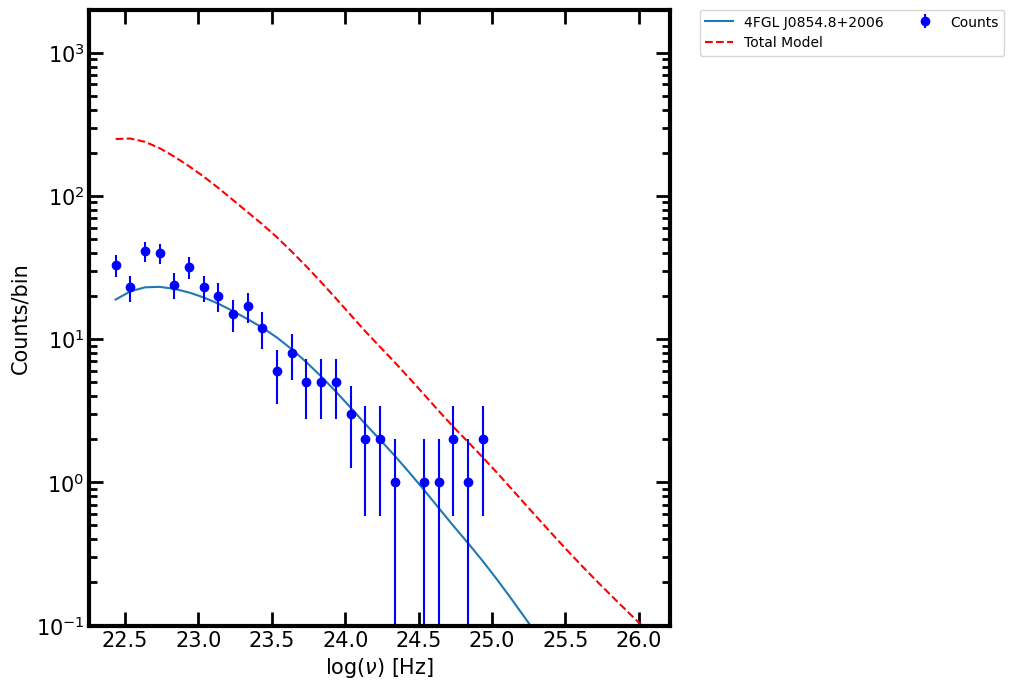

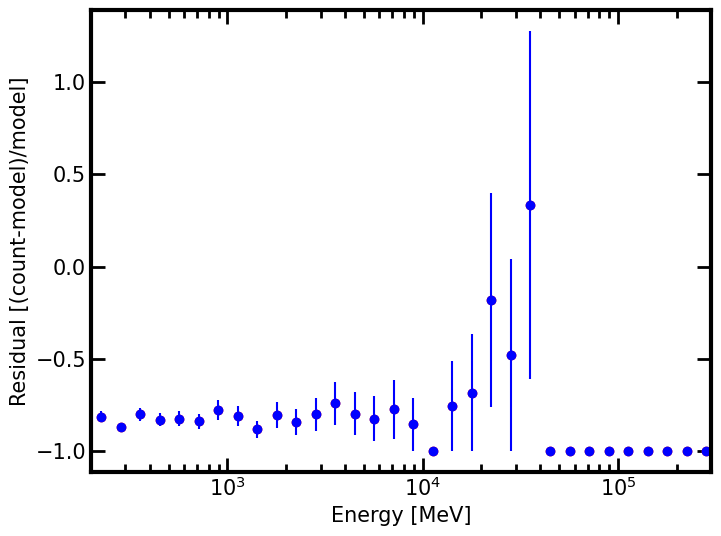

In [5]:
#######################################################################################################
### see photon count per bin of each source 
#######################################################################################################
### calculate energy bin
E = (like.energies[:-1] + like.energies[1:])/2.
### transform frequency to energy
freq = E*1.0E6/(4.1356E-15)
name_list = list( like.sourceNames() )
count = list(like.nobs)

### calculate total model
sum_model = np.zeros_like(like._srcCnts(like.sourceNames()[0]))
for sourceName in like.sourceNames():
    sum_model = sum_model + like._srcCnts(sourceName)

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['axes.linewidth'] = 3
    
fig, ax = plt.subplots()

### to plot all of the possible source
#for i in range(19, 20):   ### len(name_list)
#    plt.plot(np.log10(freq), like._srcCnts(name_list[i]), label = name_list[i] )

### to plot the best source (highest Ts source)
plt.plot(np.log10(freq), like._srcCnts(best_source), label = best_source )

plt.plot(np.log10(freq), sum_model, '--', color = 'red', label = 'Total Model')
plt.errorbar(np.log10(freq), count, yerr = np.sqrt(like.nobs), color = 'blue', fmt = 'o', label = 'Counts')

plt.xlabel('log($\\nu$) [Hz]',  fontsize = 15)
plt.ylabel('Counts/bin',  fontsize = 15)

#plt.xlim(22, 23)
plt.ylim(0.1, 2e3)
ax.set_yscale('log')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])

plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad=0., ncol = 2)

ax.tick_params(width = 2, direction = "in", length = 10, labelsize = 15)
ax.tick_params(which = 'minor', direction = "in", width = 2, length = 6, color = 'k')

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

#######################################################################################################
### examine the quality of total count with the model
#######################################################################################################
residual = (like.nobs - sum_model)/sum_model   
resid_err = np.sqrt(like.nobs)/sum_model

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.linewidth'] = 3
    
fig, ax = plt.subplots()

plt.plot(E, residual, 'o', color = 'red')
plt.errorbar(E, residual, yerr = resid_err, color = 'blue', fmt = 'o')

plt.xlabel('Energy [MeV]',  fontsize = 15)
plt.ylabel('Residual [(count-model)/model]',  fontsize = 15)

plt.xlim(200, 300000)
#plt.ylim(-1.01, 115)


#plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad=0., ncol = 2)

ax.set_xscale('log')

ax.tick_params(width = 2, direction = "in", length = 10, labelsize = 15)
ax.tick_params(which = 'minor', direction = "in", width = 2, length = 6, color = 'k')

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')


/var/folders/94/t26sjbcn6556mfzt3vm0j5dm0000gn/T/ipykernel_84245/392034616.py:68: RuntimeWarning: divide by zero encountered in log10
  ax.errorbar(np.log10(freq_ori), np.log10(flux_ori), yerr = flux_err_ori, marker = "o", color = "red", ecolor = "red", linestyle = '', label = 'Total SED')


Text(0.5, 1.0, 'J0854+2006 SED Test')

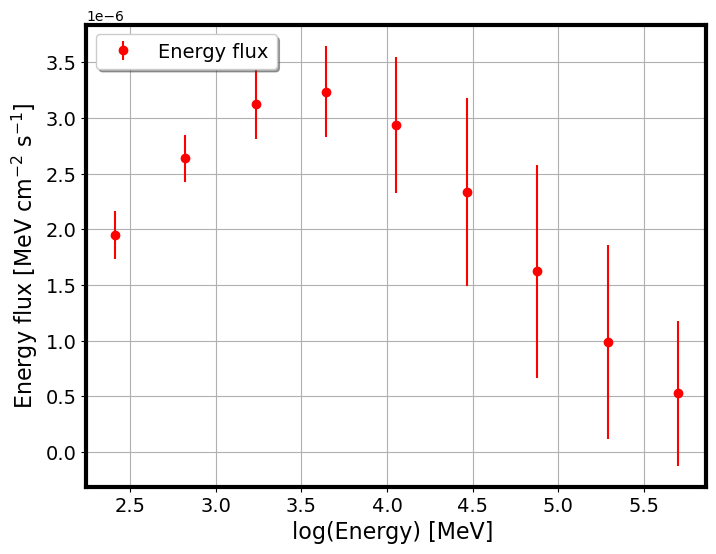

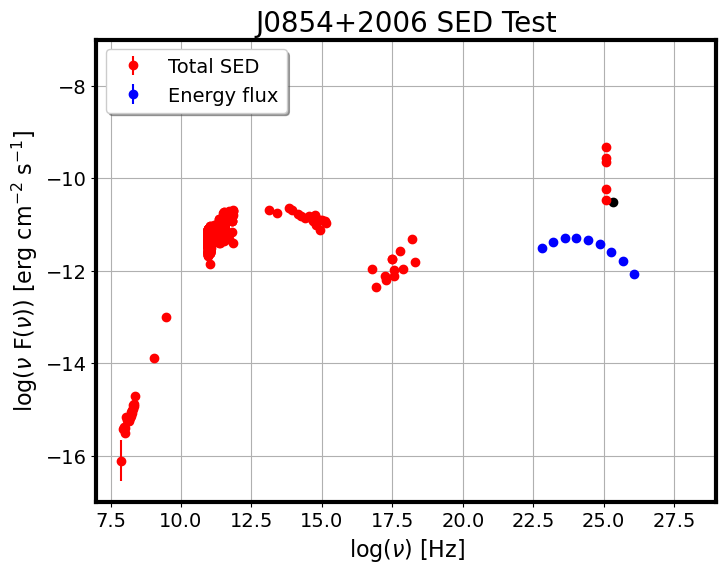

In [37]:
#######################################################################################################
### overplot gamma-ray upper limit constrain to the original SED 
#######################################################################################################
### Read original SED data
test = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/source individual flux 11_15/' + source_name + '_flux.csv') 

freq_ori = test.freq.values
flux_ori = test.flux.values
flux_err_ori = test.flux_err.values

### create energy bin
energy_bin = 10**np.linspace( np.log10(np.min(like.energies)), np.log10(np.max(like.energies)), 10)

fermi_freq = []
flux_array = []
flux_err_array = []

fermi_energy = []
energyflux_array = []
energyflux_err_array = []

### transform counts into flux density
for i in range(0, len(energy_bin)-1):
    ### if "like.flux" set "energyFlux = True" = using "like.energyFlux", giving energy flux in the unit of [MeV/cm^2/s]
    flux = like.flux(best_source, emin = energy_bin[i], emax = energy_bin[i+1], energyFlux = False)
    flux_array.append(flux)
    
    flux_err = like.fluxError(best_source, emin = energy_bin[i], emax = energy_bin[i+1])
    flux_err_array.append(flux_err)
    
    energyflux = like.energyFlux(best_source, emin = energy_bin[i], emax = energy_bin[i+1])
    energyflux_array.append(energyflux)
    
    energyflux_err = like.energyFluxError(best_source, emin = energy_bin[i], emax = energy_bin[i+1])
    energyflux_err_array.append(energyflux_err)
    
    log_low_energy = np.log10(energy_bin[i])
    log_high_energy = np.log10(energy_bin[i+1]) 
    log_energy_diff = log_high_energy-log_low_energy 
    log_energy = log_low_energy+log_energy_diff
    
    fermi_energy.append(log_energy)
    fermi_freq.append(10**log_energy*1.0E6/(4.1356E-15))
    
#######################################################################################################
### plot flux [erg/cm^2/s] vs. photon counts
#######################################################################################################
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.linewidth'] = 3
fig, ax = plt.subplots()

ax.errorbar(fermi_energy, energyflux_array, yerr = energyflux_err_array, marker = "o", color = "red", ecolor = "red", linestyle = '', label = 'Energy flux') 

plt.legend(loc = 'upper left', shadow = True, fontsize = 14, markerscale = 1) 

plt.xlabel( "log(Energy) [MeV] ",  fontsize = 16)
plt.xticks(fontsize = 14)
plt.ylabel('Energy flux [MeV $\mathrm{cm^{-2}\ s^{-1}}$]',  fontsize = 16)
plt.yticks(fontsize = 14)
plt.grid(True)

#######################################################################################################
### plot original SED + upper limit constrain data point 
#######################################################################################################
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.linewidth'] = 3
fig, ax = plt.subplots()

ax.errorbar(np.log10(freq_ori), np.log10(flux_ori), yerr = flux_err_ori, marker = "o", color = "red", ecolor = "red", linestyle = '', label = 'Total SED') 
### plot the fermi photon flux [ph/cm^2/s] 
#ax.errorbar(np.log10(fermi_freq), np.log10(flux_array), yerr = 0.434*np.array(flux_err_array)/flux_array
#            , marker = "o", color = "green", ecolor = "green", linestyle = '', label = 'Photon flux') 
### plot the fermi energy flux
ax.errorbar(np.log10(fermi_freq), np.log10(np.array(energyflux_array)*1.6022E-6), yerr = 0.434*(np.array(energyflux_err_array)*1.6022E-6/np.array(energyflux_array)*1.6022E-6)
            , marker = "o", color = "blue", ecolor = "blue", linestyle = '', label = 'Energy flux') 
### plot the point that sum over fermi energy flux
plt.plot(np.log10(np.mean(fermi_freq)), np.log10(np.sum(np.array(energyflux_array)*1.6022E-6)), 'o', color = 'black')

ax.set_xlim(7, 29)
ax.set_ylim(-17, -7) 

plt.legend(loc = 'upper left', shadow = True, fontsize = 14, markerscale = 1) 

plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 16)
plt.xticks(fontsize = 14)
plt.ylabel('log($\\nu$ F($\\nu$)) [erg $\mathrm{cm^{-2}\ s^{-1}}$]',  fontsize = 16)
plt.yticks(fontsize = 14)
plt.grid(True)
figurename = source_name+' SED Test'
plt.title(figurename, fontsize = 20)
